# Linear Elasticity-Nonlinear Hardening

This example can be found in Section 5.5 in the following paper: [A Tutorial on Bayesian Inference to Identify Material Parameters in Solid Mechanics](https://doi.org/10.1007/s11831-018-09311-x)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Times New Roman"],
    }
)
plt.rcParams["font.family"] = "Times New Roman"

## 1. Material model

In [2]:
def compute_stress(E, stress_y, H, n, strains):
    """
    Linear elastic-nonlinear hardening material
    """
    stress = []
    strain_y = stress_y / E

    for strain in strains:
        if strain <= strain_y:
            stress.append(E * strain)
        else:
            strain_p = strain - strain_y
            stress.append(stress_y + (H * strain_p**n))

    return stress

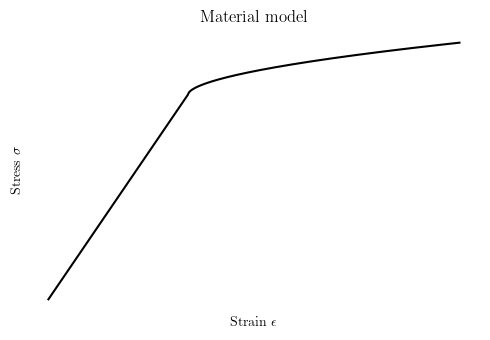

In [3]:
E = 210
stress_y = 0.25
H = 2
n = 0.57
strain = np.linspace(0, 3.5e-3, 1000)
stress = compute_stress(E, stress_y, H, n, strain)

plt.figure(figsize=(5, 3.5))
plt.plot(strain, stress, color='k')
plt.title("Material model")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.gca().set_frame_on(False)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("figures/linear-elastic-perfectly-plastic-material-model.png", dpi=300)

In [4]:
class BaseModel:
    """
    Base class for models used in Bayesian inference.

    Subclasses must implement the __call__ method.
    """

    def __init__(self, x):
        """
        x : list or array-like
            The independent variables (e.g., strain).
        """
        self.x = x

    def __call__(self, *args, **kwargs):
        """
        Define the behaviour of the model.

        Parameters
        ----------
        *args : tuple
            Positional arguments.

        **kwargs : dict
            Keyword arguments.

        Returns
        -------
        Any
            The output of the model.
        """
        raise NotImplementedError("Subclasses must implement __call__ method.")


class LinearElasticNonlinearHardening(BaseModel):
    """
    Linear elastic-nonlinear hardening material
    """

    def __init__(self, x, y_observed):
        """
        Parameters
        ----------
        x : list or array-like
            The independent variables (e.g., strain).

        y_observed : list or array-like
            The observed values of the dependent variables (e.g., stress).
        """
        super().__init__(x)
        self.y_observed = y_observed

    def __call__(self, parameters):
        """
        Compute stress based on the provided parameters.

        Parameters
        ----------
        parameters : list
            Model parameters (Young's Modulus and Yield Stress)

        Returns
        -------
        stress : list
            Computed stress values for each strain in x.
        """
        if len(parameters) != 4:
            raise ValueError(
                "LinearElasticNonlinearHardening model expects four parameters."
            )

        E, stress_y, H, n = parameters
        stress = []
        strain_y = stress_y / E
    
        for strain in self.x:
            if strain <= strain_y:
                stress.append(E * strain)
            else:
                strain_p = strain - strain_y
                stress.append(stress_y + (H * strain_p**n))
    
        return stress

    def evaluate(self, candidate):
        return np.mean((self.y_observed - self(candidate)) ** 2)

## 2. Genererating synthetic data

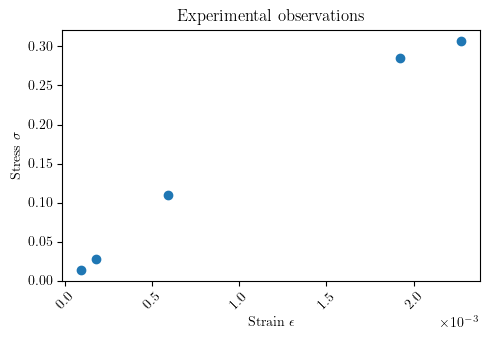

In [5]:
np.random.seed(1) # 19, 22, 23

sigma = 0.01  # standard deviation of the noise
n_observations = 5
x = np.linspace(0, 2.5e-3, 1000)
strain_observed = np.random.choice(x, n_observations)
stress_observed = compute_stress(E, stress_y, H, n, strain_observed) + np.random.normal(
    scale=sigma, size=strain_observed.shape[0]
)

plt.figure(figsize=(5, 3.5))
plt.scatter(strain_observed, stress_observed, label="Observation")
plt.title("Experimental observations")
plt.xlabel("Strain $\epsilon$")
plt.ylabel("Stress $\sigma$")
plt.xticks(rotation=45)
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2, 2)) 
# plt.legend()
plt.tight_layout()
plt.savefig("figures/linear-elastic-nonlinear-hardening-experimental-observations.png", dpi=300)

## 3. Optimisation

In [6]:
class GradientDescent:

    def __init__(self, model, initial_candidate=None, num_random_starts=5):
        self.model = model
        self.initial_candidate = initial_candidate
        self.num_random_starts = int(num_random_starts)

    def optimise(self, step_size, n_steps=100, momentum=0.9, batch_size=1):
        """
        Optimise the cost function using stochastic gradient descent with momentum.

        Parameters:
        step_size (float): Learning rate for the gradient descent.
        n_steps (int): Number of iterations for the gradient descent.
        momentum (float): Momentum factor.
        batch_size (int): Number of data points to use in each mini-batch.

        Returns:
        """
        best_candidate = None
        best_cost = float('inf')
        best_candidate_hist = None
        best_cost_hist = None

        for _ in range(self.num_random_starts):
            if self.initial_candidate is not None:
                self.candidate = np.copy(self.initial_candidate)
            else:
                self.candidate = np.random.randn(2)

            cost_hist = []
            candidate_hist = []

            velocity = np.zeros_like(self.candidate)

            for _ in range(n_steps):
                gradient = self._compute_gradient(batch_size)
                velocity = momentum * velocity - step_size * gradient
                self.candidate += velocity
                candidate_hist.append(np.copy(self.candidate))
                cost = self._cost_function(self.candidate)
                cost_hist.append(cost)

            if cost_hist[-1] < best_cost:
                best_cost = cost_hist[-1]
                best_candidate = np.copy(self.candidate)
                best_candidate_hist = candidate_hist
                best_cost_hist = cost_hist

        return np.array(best_candidate_hist), best_cost_hist

    def _compute_gradient(self, batch_size, h=1e-5):
        """
        Compute the gradient of the cost function using a mini-batch of data points
        with the finite difference method.

        Parameters:
        batch_size (int): Number of data points to use in each mini-batch.
        h (float, optional): The step size for the finite difference approximation. Default is 1e-5.

        Returns:
        numpy array: The gradient of the cost function at the current candidate parameters.
        """
        x = self.candidate
        gradient = np.zeros_like(x)

        indices = np.random.choice(2, batch_size, replace=False)

        for i in indices:
            x_forward, x_backward = np.copy(x), np.copy(x)
            x_forward[i] += h
            x_backward[i] -= h
            gradient[i] = (
                self._cost_function(x_forward) - self._cost_function(x_backward)
            ) / (2 * h)

        return gradient

    def _cost_function(self, candidate):
        return self.model.evaluate(candidate)

In [7]:
model = LinearElasticNonlinearHardening(strain_observed, stress_observed)
initial_params = np.array([220, 0.29, 2.5, 0.5])
optimiser = GradientDescent(model, initial_params)
candidate_hist, cost_hist = optimiser.optimise(
    step_size=np.array([100, 0.1, 0.1, 0.1]), n_steps=10000
)

print("Optimised Parameters:", candidate_hist[-1])
print("Final Error:", cost_hist[-1])

Optimised Parameters: [199.14305865   0.21695555   2.5          0.5       ]
Final Error: 3.5801789562602695e-05


### 3.1 Plot the cost history

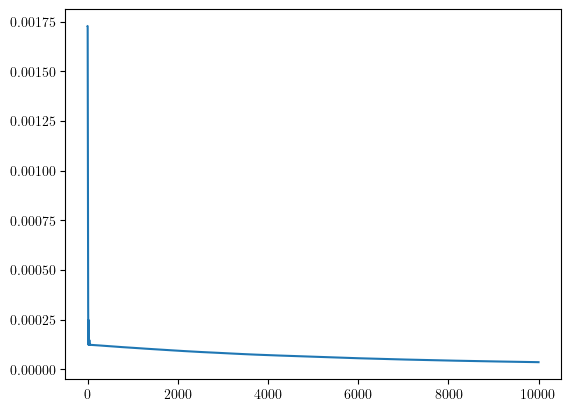

In [8]:
plt.plot(cost_hist)

## 4. Prior

In [9]:
class Prior:

    def __init__(self, mean=np.array([0, 0]), std_dev=np.array([1, 1])):
        """
        Initialise the multivariate normal prior distribution.

        Parameters
        ----------
        mean : array-like, optional
            Mean vector of the multivariate normal distribution. Default is np.array([0, 0]).

        std_dev : array-like
            Standard deviation vector of the multivariate normal distribution. Default is np.array([1, 1]).
        """
        self.mean = np.array(mean)
        self.std_dev = np.array(std_dev)
        self.cov = np.diag(self.std_dev**2)

    def evaluate(self, x):
        """
        Evaluate the prior function at the given value(s) of x.

        Parameters
        ----------
        x : array-like
            The value(s) at which to evaluate the prior function.

        Returns
        -------
        array-like
            The prior probability density at the given value(s).
        """
        return scipy.stats.multivariate_normal.pdf(x, mean=self.mean, cov=self.cov)

    def plot(self, x_values):
        """
        Plot the prior function over a range of x values.

        Parameters
        ----------
        x_values : array-like
            The range of x values for plotting.
        """
        prior_values = self.evaluate(x_values)
        # plt.contourf()

## 5. Likelihood

In [10]:
class Likelihood:

    def __init__(self, y, sigma, model):
        """
        y : ndarray
            Observed data
        """
        self.y = y
        self.sigma = sigma
        self.model = model

    def evaluate(self, x):
        """
        x : float or array-like
            The value(s) of the model parameters.
        """
        residual = self._compute_residual(x)
        return (
            1
            / (self.sigma * np.sqrt(2 * np.pi))
            * np.exp(-0.5 * (residual / self.sigma**2))
        )

    def _compute_residual(self, x):
        return np.sum((self.y - self.model(x)) ** 2)

## 6. Posterior

In [11]:
class Posterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood

    def evaluate(self, x):
        """
        Compute the posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The posterior probability distribution for the given model parameters.
        """
        return self.prior.evaluate(x) * self.likelihood.evaluate(x)

In [12]:
class LogPosterior:

    def __init__(self, prior, likelihood):
        self.prior = prior
        self.likelihood = likelihood
        self.eps = 1e-10

    def evaluate(self, x):
        """
        Compute the log posterior distribution for given model parameters and observed data.

        Parameters
        ----------
        x : float or array-like
            The value(s) of the model parameters.

        Returns
        -------
        float or array-like
            The logarithm of the posterior probability distribution for the given model parameters.
        """
        return np.log(self.prior.evaluate(x) + self.eps) + np.log(self.likelihood.evaluate(x) + self.eps)

In [13]:
prior = Prior(mean=np.array([200, 0.29, 1.5, 0.5]), std_dev=np.array([25, 0.02, 1.0, 0.5]))
likelihood = Likelihood(stress_observed, sigma, model)
posterior = Posterior(prior, likelihood)

## 7. Adaptive Metropolis Hastings

In [14]:
from tqdm import tqdm


class Sampler:

    def __init__(self, posterior, proposal, steps, init):
        self.posterior = posterior
        self.proposal = proposal
        self.steps = int(steps)  # n_samples
        self.init = init
        self.samples = None

    def sample(self):
        """
        Sampling
        """
        self.samples = [self.init.copy()]
        for _ in tqdm(range(self.steps), desc="Sampling"):
            self._sample_step()

    def get_samples(self):
        """
        Returns the samples
        """
        return np.array(self.samples)

    def _sample_step(self):
        """
        Draw a new sample
        """
        point = self.samples[-1]
        proposal = self.proposal.draw(self.samples)
        self.samples.append(self._accept_or_reject(point, proposal))

    def _accept_or_reject(self, x_i, x_p):
        """
        Accept of reject a new candidate

        Parameters
        ----------
        x_i : ndarray
            Current sample

        x_p : ndarray
            New sample (x_p) is proposed by drawing from a proposal
            distribution

        n_accept : int
            Count of accepted samples

        Returns
        -------

        """
        alpha = self._compute_acceptance_ratio(x_i, x_p)
        u = np.random.uniform(low=0.0, high=1.0)
        if u <= alpha:  # Accept proposal
            return x_p
        else:  # Reject proposal
            return x_i

    def _compute_acceptance_ratio(self, x_i, x_p):
        return min(1, self.posterior.evaluate(x_p) / self.posterior.evaluate(x_i))


class MetropolisHastings(Sampler):
    pass

In [15]:
class Proposal:
    """
    Proposal class

    TODO: look at pysampler/proposal.py
    """

    def __init__(self, step_size):
        self.step_size = step_size

    def draw(self, samples):
        return np.random.normal(samples[-1], self.step_size)


class GaussianProposal(Proposal):
    pass


class AdaptiveProposal:
    """
    Adaptive proposal class - update the the covariance matrix of the proposal
    distribution using existing knowledge of the posterior

    Haario, H., Saksman, E., and Tamminen, J. (1999). Adaptive proposal
    distribution for random walk metropolis algorithm. Computational
    Statistics, 14(3):375-395. 1, 2

    Attributes
    ----------
    update_freq: int
        Proposal distribution update frequency (default = 1000). The
        frequency at which the proposal distribution is updated.

    n_K : ndarray
        Number of samples / update frequency

    R_0 : ndarray (floats)
        Initial covariance matrix (this can be chosen as the identify matrix
        if you have no prior knowledge)

    R_t : ndarray (floats)
        Updated covariance matrix

    i : int
        Counter to track how many times the proposal has been called

    Notes
    -----
    - TODO: is n_K equal to n_samples?
    - TODO: gamma is missing from the draw method
    """

    def __init__(self, cov, step_size=2.38, update_freq=1000):
        self.cov = cov
        self.step_size = step_size
        self.update_freq = update_freq
        self.R_t = cov
        self.i = 0

    def draw(self, samples):
        """
        Draw x (candidate) from proposal distribution q

        Parameters
        ----------
        x_i : ndarray
            Current sample

        Returns
        -------
        x_p : ndarray
            Proposed sample (candidate sample)

        """
        self.i += 1
        if self.i % self.update_freq == 0:
            self._adapt_cov(samples)
        return np.random.multivariate_normal(samples[-1], self.R_t)

    def _adapt_cov(self, K):
        """
        Parameters
        ----------
        K : ndarray

        Returns
        -------
        R_t : ndarray (floats)
            Updated covariance matrix
        """
        K_tilde = self._compute_K_tilde(K)
        self.R_t = (1 / (len(K) - 1)) * np.matmul(np.transpose(K_tilde), K_tilde)

    def _compute_K_tilde(self, K):
        """
        Calculate the centred matrix

        Parameters
        ----------
        K : ndarray
            Sample chain - all previous samples are stored in matrix K of size
            n_k x n_p, where n_k is... and n_p is the number of unknown
            parameters. Each row represents one sampled point.

        K_mean : ndarray
            History (evolution) of mean value of all previous samples
            (n_samples x n_p)

        Returns
        -------
        K_tilde : ndarray
            The centred matrix n_K x n_p (K_tilde = K - E[K])
        """
        return K - np.mean(K, 0)

In [16]:
proposal = Proposal(np.array([2.5, 0.05, 0.1, 0.05]))
mh = Sampler(posterior, proposal, 1e5, np.array([150, 0.1, 1.5, 0.5]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12701.87it/s]


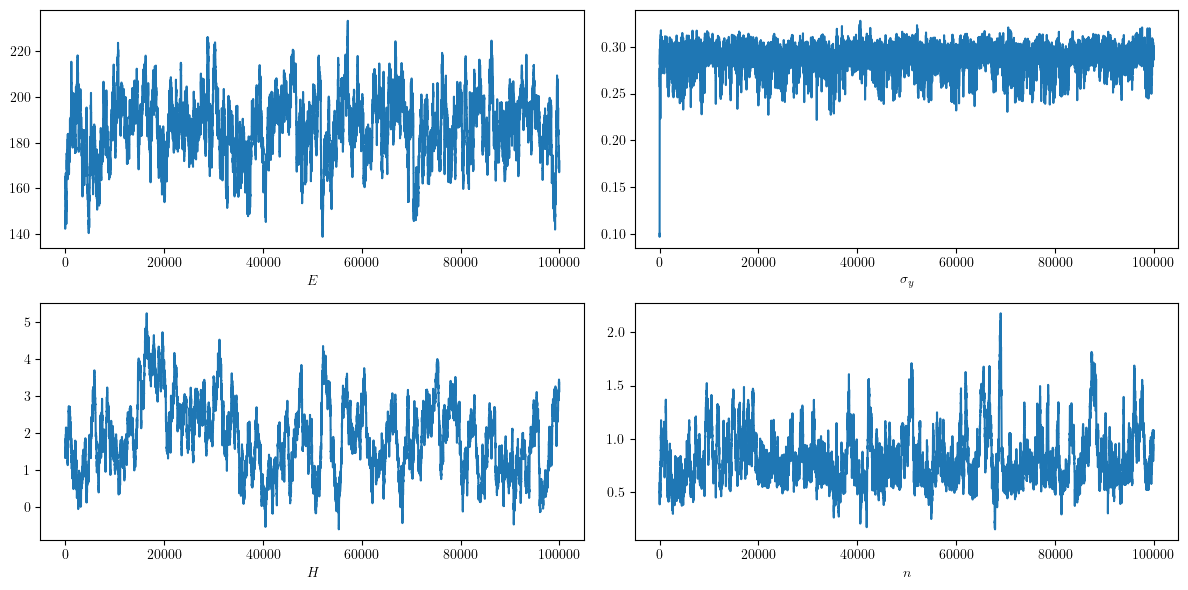

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax3.plot(samples[:, 2])
ax4.plot(samples[:, 3])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\sigma_y$")
ax3.set_xlabel("$H$")
ax4.set_xlabel("$n$")
plt.tight_layout()

In [18]:
proposal = AdaptiveProposal(cov=np.eye(4), step_size=[1, 1, 1, 1])
mh = Sampler(posterior, proposal, 1e5, np.array([150, 0.1, 1.5, 0.5]))
mh.sample()
samples = mh.get_samples()

Sampling: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [00:09<00:00, 10371.83it/s]


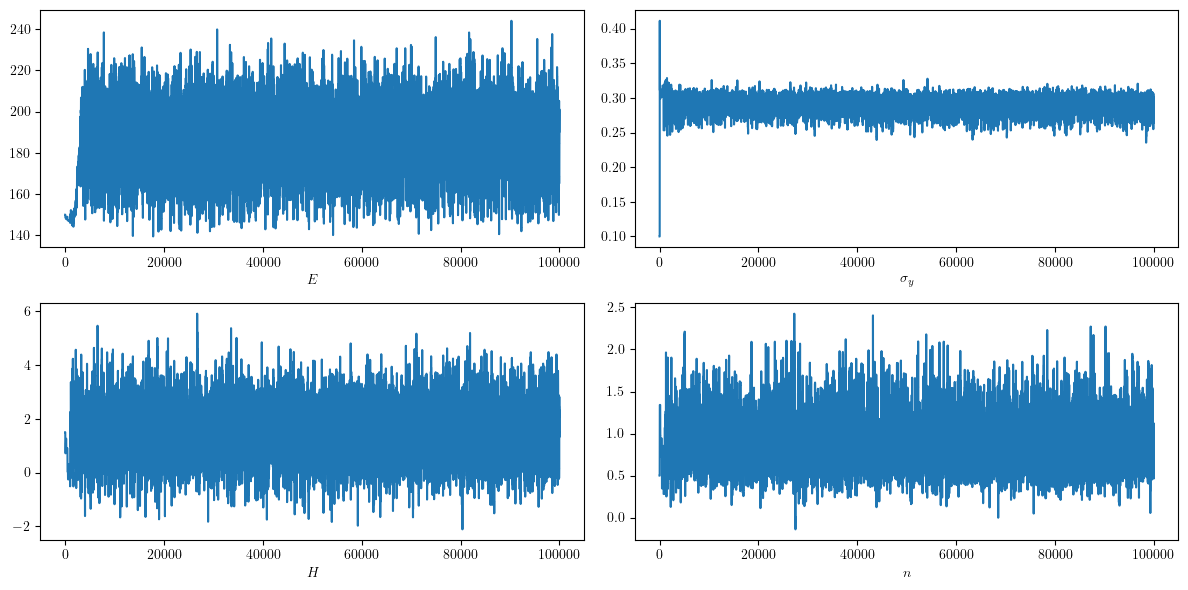

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
ax1.plot(samples[:, 0])
ax2.plot(samples[:, 1])
ax3.plot(samples[:, 2])
ax4.plot(samples[:, 3])
ax1.set_xlabel("$E$")
ax2.set_xlabel("$\sigma_y$")
ax3.set_xlabel("$H$")
ax4.set_xlabel("$n$")
plt.tight_layout()
fig.savefig("figures/chain.png", dpi=300, bbox_inches="tight")

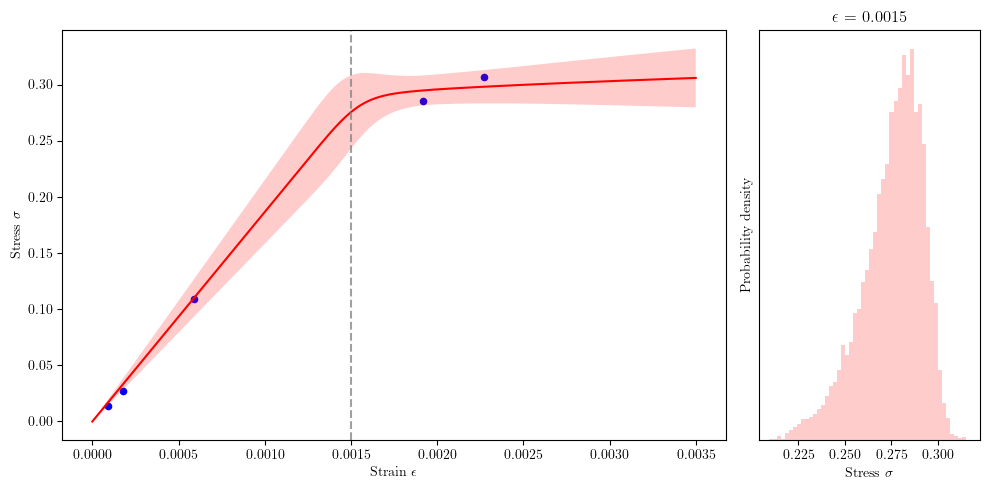

In [22]:
predictions = np.array(
    [compute_stress(sample[0], sample[1], sample[2], sample[3], strain) for sample in samples[10000:]]
)

posterior_predictive_mean = np.mean(predictions, axis=0)
posterior_predictive_std = np.std(predictions, axis=0)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]}
)

ax1.scatter(strain_observed, stress_observed, color="blue", s=20)
# ax1.plot(strain, stress, "k--", label="True")
ax1.plot(
    strain, posterior_predictive_mean, color="red", label="Posterior Predictive Mean"
)
ax1.fill_between(
    strain,
    posterior_predictive_mean - 2 * posterior_predictive_std,
    posterior_predictive_mean + 2 * posterior_predictive_std,
    color="red",
    alpha=0.2,
    edgecolor='none',
    label="Posterior Predictive Distribution",
)

marginal_value = 0.0015
marginal_index = np.abs(strain - marginal_value).argmin()
marginal_posterior = predictions[:, marginal_index]
ax1.axvline(marginal_value, linestyle="--", color="grey", alpha=0.75)

ax1.set_xlabel("Strain $\epsilon$")
ax1.set_ylabel("Stress $\sigma$")
# ax1.legend()

ax2.hist(marginal_posterior, bins=50, density=True, alpha=0.2, color="red")
ax2.set_xlabel(f"Stress $\sigma$")
ax2.set_ylabel("Probability density")
ax2.tick_params(labelleft=False)
ax2.set_yticks([])
ax2.set_title(f"$\epsilon$ = {marginal_value}")

plt.tight_layout()
plt.savefig("figures/posterior-predictive-distribution.png", dpi=300)
plt.show()

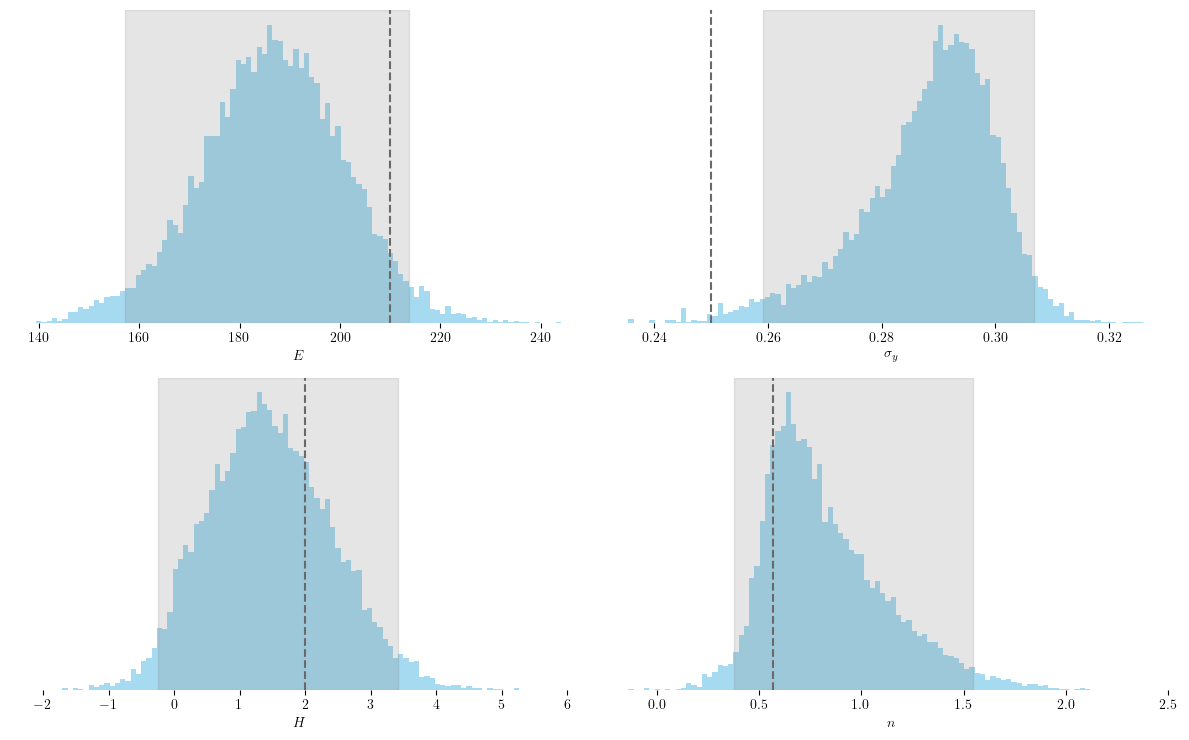

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7.5))

credible_interval_E = np.percentile(samples[10000:, 0], [2.5, 97.5])
credible_interval_eps = np.percentile(samples[10000:, 1], [2.5, 97.5])
credible_interval_H = np.percentile(samples[10000:, 2], [2.5, 97.5])
credible_interval_n = np.percentile(samples[10000:, 3], [2.5, 97.5])

ax1.hist(samples[10000:, 0], bins=100, density=True, alpha=0.75, color="skyblue")
ax1.axvline(E, ls="--", color="dimgray")
ax1.axvspan(credible_interval_E[0], credible_interval_E[1], color="gray", alpha=0.2, label="95% CI")
ax1.set_xlabel("$E$")
ax1.tick_params(labelleft=False)
ax1.set_frame_on(False)
ax1.set_yticks([])

ax2.hist(samples[10000:, 1], bins=100, density=True, alpha=0.75, color="skyblue")
ax2.axvline(stress_y, ls="--", color="dimgray")
ax2.axvspan(credible_interval_eps[0], credible_interval_eps[1], color="gray", alpha=0.2, label="95% CI")
ax2.set_xlabel("$\sigma_y$")
ax2.tick_params(labelleft=False)
ax2.set_frame_on(False)
ax2.set_yticks([])

ax3.hist(samples[10000:, 2], bins=100, density=True, alpha=0.75, color="skyblue")
ax3.axvline(H, ls="--", color="dimgray")
ax3.axvspan(credible_interval_H[0], credible_interval_H[1], color="gray", alpha=0.2, label="95% CI")
ax3.set_xlabel("$H$")
ax3.tick_params(labelleft=False)
ax3.set_frame_on(False)
ax3.set_yticks([])

ax4.hist(samples[10000:, 3], bins=100, density=True, alpha=0.75, color="skyblue")
ax4.axvline(n, ls="--", color="dimgray")
ax4.axvspan(credible_interval_n[0], credible_interval_n[1], color="gray", alpha=0.2, label="95% CI")
ax4.set_xlabel("$n$")
ax4.tick_params(labelleft=False)
ax4.set_frame_on(False)
ax4.set_yticks([])

plt.tight_layout()
plt.savefig("figures/histograms.png", dpi=300)